In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

# use the CAMB cosmology that generated the matter power spectra
import camb
from cosmology import Cosmology

# GLASS modules: cosmology and everything in the glass namespace
import glass.shells
import glass.fields
import glass.points
import glass.shapes
import glass.lensing
import glass.galaxies
import glass.observations
import glass.ext.camb

In [2]:
# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05

# basic parameters of the simulation
nside = lmax = 256

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2,
                       NonLinear=camb.model.NonLinear_both)

# get the cosmology from CAMB
cosmo = Cosmology.from_camb(pars)

In [21]:
# shells of 200 Mpc in comoving distance spacing
zb = glass.shells.distance_grid(cosmo, 0., 3., dx=200.)

# tophat window functions for shells
ws = glass.shells.tophat_windows(zb)

# compute the angular matter power spectra of the shells with CAMB
cls = glass.ext.camb.matter_cls(pars, lmax, ws)

# compute Gaussian cls for lognormal fields for 3 correlated shells
# putting nside here means that the HEALPix pixel window function is applied
gls = glass.fields.lognormal_gls(cls, nside=nside, lmax=lmax, ncorr=3)

# generator for lognormal matter fields
matter = glass.fields.generate_lognormal(gls, nside, ncorr=3)

In [4]:
# galaxy density (using 1/100 of the expected galaxy number density for Stage-IV)
n_arcmin2 = 0.3

# true redshift distribution following a Smail distribution
z = np.arange(0., 3., 0.01)
dndz = glass.observations.smail_nz(z, z_mode=0.9, alpha=2., beta=1.5)
dndz *= n_arcmin2

# compute tomographic redshift bin edges with equal density
nbins = 10
zbins = glass.observations.equal_dens_zbins(z, dndz, nbins=nbins)

# photometric redshift error
sigma_z0 = 0.03

# constant bias parameter for all shells
bias = 1.2

# ellipticity standard deviation as expected for a Stage-IV survey
sigma_e = 0.27

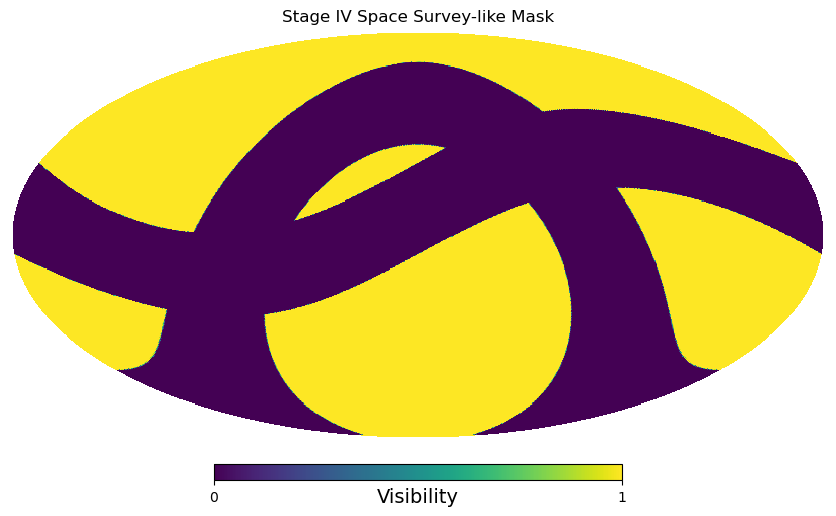

In [7]:
vis = glass.observations.vmap_galactic_ecliptic(nside)

# checking the mask:
hp.mollview(vis, title='Stage IV Space Survey-like Mask', unit='Visibility')


In [19]:
for i, delta_i in enumerate(matter):
    hp.mollview(np.asarray(delta_i))

In [22]:
# we will store the catalogue as a structured numpy array, initially empty
catalogue = np.empty(0, dtype=[('RA', float), ('DEC', float),
                               ('redshift', float)])

# simulate the matter fields in the main loop, and build up the catalogue
for i, delta_i in enumerate(matter):

    # the true galaxy distribution in this shell
    z_i, dndz_i = glass.shells.restrict(z, dndz, ws[i])

    # integrate dndz to get the total galaxy density in this shell
    ngal = np.trapz(dndz_i, z_i)
    
    # generate galaxy positions from the matter density contrast
    for gal_lon, gal_lat, gal_count in glass.points.positions_from_delta(ngal, delta_i, bias, vis):

        # generate random redshifts from the provided nz
        gal_z = glass.galaxies.redshifts_from_nz(gal_count, z_i, dndz_i)

        # make a mini-catalogue for the new rows
        rows = np.empty(gal_count, dtype=catalogue.dtype)
        rows['RA'] = gal_lon
        rows['DEC'] = gal_lat
        rows['redshift'] = gal_z
        
        # add the new rows to the catalogue
        catalogue = np.append(catalogue, rows)

print(f'Total number of galaxies sampled: {len(catalogue):,}')

Total number of galaxies sampled: 22,272,225


In [23]:
# we will store the catalogue as a structured numpy array, initially empty
catalogue = np.empty(0, dtype=[('RA', float), ('DEC', float),
                               ('redshift', float)])

# simulate the matter fields in the main loop, and build up the catalogue
for i, delta_i in enumerate(matter):

    # the true galaxy distribution in this shell
    z_i, dndz_i = glass.shells.restrict(z, dndz, ws[i])

    # integrate dndz to get the total galaxy density in this shell
    ngal = np.trapz(dndz_i, z_i)
    
    # generate galaxy positions from the matter density contrast
    for gal_lon, gal_lat, gal_count in glass.points.positions_from_delta(ngal, delta_i, bias, vis):

        # generate random redshifts from the provided nz
        gal_z = glass.galaxies.redshifts_from_nz(gal_count, z_i, dndz_i)

        # make a mini-catalogue for the new rows
        rows = np.empty(gal_count, dtype=catalogue.dtype)
        rows['RA'] = gal_lon
        rows['DEC'] = gal_lat
        rows['redshift'] = gal_z
        
        # add the new rows to the catalogue
        catalogue = np.append(catalogue, rows)

print(f'Total number of galaxies sampled: {len(catalogue):,}')

array([( 16.05434453,  89.0082521 , 0.04488374),
       (  5.87326907,  86.94454864, 0.04548198),
       ( 18.12400377,  86.57148998, 0.04180219), ...,
       (329.51500671, -89.17780307, 2.98550676),
       (287.62232566, -89.47941168, 2.91990332),
       (154.7891491 , -89.52381413, 2.88702093)],
      dtype=[('RA', '<f8'), ('DEC', '<f8'), ('redshift', '<f8')])

In [29]:
from tqdm import tqdm

In [30]:
tqdm?

Init signature: tqdm(*_, **__)
Docstring:     
Decorate an iterable object, returning an iterator which acts exactly
like the original iterable, but prints a dynamically updating
progressbar every time a value is requested.
Init docstring:
Parameters
----------
iterable  : iterable, optional
    Iterable to decorate with a progressbar.
    Leave blank to manually manage the updates.
desc  : str, optional
    Prefix for the progressbar.
total  : int or float, optional
    The number of expected iterations. If unspecified,
    len(iterable) is used if possible. If float("inf") or as a last
    resort, only basic progress statistics are displayed
    (no ETA, no progressbar).
    If `gui` is True and this parameter needs subsequent updating,
    specify an initial arbitrary large positive number,
    e.g. 9e9.
leave  : bool, optional
    If [default: True], keeps all traces of the progressbar
    upon termination of iteration.
    If `None`, will leave only if `position` is `0`.
file  : `